# Drift Adjusted Sharpe Ratio Optimized Portfolio Study

- Empirical analysis on the efficacy of Drift Adjusted Sharpe Ratio (Marcus's personally created risk-adjusted returns ratio) optimized portfolios.
- Study applies similar methodology to mean-variance portfolios, but optimizes for portfolio DASR. 
- In-sample DASR Optimization is directly benchmarked to MVO 
- Investment universe includes large volume ETFs covering a varitety of themes and asset classes (e.g., Large Cap Equity, Commodity, Fixed Income, Real Estate)

Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime as dt
import yfinance as yf
import statsmodels.api as sm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

from backtest_tools import portfolio_tools as pt, risk_analysis as ra


Download ETF Returns

In [7]:
assets = ['SPY', 'QQQ', 'SPTM', 'MDY', 'IEFA', 'EEM', 'LQD', 'TLT', 'XLE', 'DBC', 'XLRE', 'GLD', 'IEF', 'SLV', 'DBA','JNK', 'HYG'] # , 'BIL']
# assets = ['BIL']
# Returns of opening prices
open_asset_returns = pd.DataFrame()
# Returns of close prices
close_asset_returns = pd.DataFrame()


for ticker in assets:
    prices = yf.download(ticker, start='1980-01-01', end=dt.date.today())
    
    # Get i'th asset's returns
    close_rets = prices['Adj Close'].pct_change().dropna()
    close_rets = close_rets.rename(ticker)
    open_rets = prices['Open'].pct_change().dropna()
    open_rets = open_rets.rename(ticker)

    close_asset_returns = pd.concat([close_asset_returns, close_rets], axis=1)
    open_asset_returns = pd.concat([open_asset_returns, open_rets], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# SR vs. DASR on Russell 2000 Returns

In [34]:
import pickle
path = r'C:\Users\marcu\Documents\Quant\Programming\Data\russell_300_returns.pickle'

with open(path, 'rb') as handler:
    r_2000_returns = pickle.load(handler)

In [13]:
# Apply DASR Optimization
dasr_w = max_dasr_optimization(returns=r_2000_returns, constrained=False)
# Apply Mean-Variance Optimization
mvo_w = pt.mvo(hist_returns=r_2000_returns, expected_returns=r_2000_returns.mean(), vol_target=.1, max_position_weight=3, constrained=False, verbose=False)

In [35]:
# # --------------- Plot Russell 2000 Opt Returns ---------------
n = len(r_2000_returns.columns)

# Get portfolio returns
dpo_returns = pt.scale_vol((r_2000_returns*dasr_w).sum(1))
mvo_returns = pt.scale_vol((r_2000_returns*mvo_w).sum(1))
naive_portfolio = pt.scale_vol((r_2000_returns/n).sum(1))

# Plot DASR Optimized vs. MVO vs. Naive Portfolio Returns
plt.figure(figsize=(8, 5))
plt.xlabel='Time'
plt.ylabel='Cumulative Returns'
plt.title('DASR vs. Sharpe Ratio Russell 2000 Optimized Portfolio')
pt.cumulative_returns(dpo_returns).plot(label='Drift-Adjusted Sharpe Ratio Optimization', legend=True)
pt.cumulative_returns(mvo_returns).plot(label = 'Mean Variance Optimization', legend=True)
pt.cumulative_returns(naive_portfolio).plot(label = 'Naive 1/N', legend=True)


# Drift Adjusted Sharpe Ratio vs. Sharpe Ratio on Assets

Get Max DASR & Max SR Portfolio Weights

In [24]:
# Apply DASR Optimization
dasr_w = max_dasr_optimization(returns=close_asset_returns, constrained=False)
# Apply Mean-Variance Optimization
mvo_w = pt.mvo(hist_returns=close_asset_returns, expected_returns=close_asset_returns.mean(), vol_target=.1, max_position_weight=3, constrained=False, verbose=False)

- As depeicted below, our DASR optimized portfolio resembles a much more consistent equity curve that is not highly dependent on low-probability, short-term positive returns.
- The implications of this directly impact the quality assesment of newly created "Alphas" or strategies.
- Intuitively, an equity curve that minimially deviates from its expected value is of more statistical significance and quality to a trader.
- Thus, if we have an equity curve that has a high Sharpe Ratio, but a low DASR, this could indicate a minimally significant Alpha that is driven by very few short-term upward jumps.
- As quants, we never rely on a small sample size to contribute most to our returns. 
- That's why we apply multistrategy portfolios of uncorrelated alphas which provide complimentary benefits (avoiding the all eggs in one basket bet).
- In this light, why would we, as quants who understand the mathematical validity of diversification, want a non-diversified stream of returns from the Alphas that we build? 
- The DASR captures this effect, penalizing large deviations (up or down) that could disproportionately contribute to our CAGR and incentivizing consistent, diversified + EV.

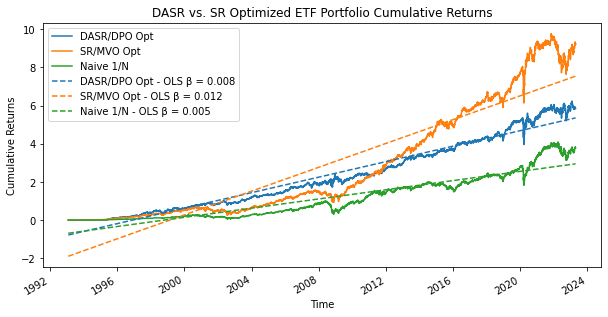

In [25]:
n = len(close_asset_returns.columns)

# Get portfolio returns
dpo_returns = pt.scale_vol((close_asset_returns*dasr_w).sum(1))
dpo_returns.name = 'DASR/DPO Opt'
mvo_returns = pt.scale_vol((close_asset_returns*mvo_w).sum(1))
mvo_returns.name = 'SR/MVO Opt'
naive_portfolio = pt.scale_vol((close_asset_returns/n).sum(1))
naive_portfolio.name = 'Naive 1/N'



cumulative_returns = pd.concat([pt.cumulative_returns(dpo_returns), pt.cumulative_returns(mvo_returns), pt.cumulative_returns(naive_portfolio)], axis=1)
cumulative_returns.plot(title='DASR vs. SR Optimized ETF Portfolio Cumulative Returns', figsize=(10, 5), xlabel='Time', ylabel='Cumulative Returns')

color = {'DASR/DPO Opt':'#1f77b4', 'SR/MVO Opt':'#ff7f0e', 'Naive 1/N':'#2ca02c'}

# Plot OLS of Cumulative Returns
ols = LinearRegression()


for i, cum_rets in cumulative_returns.items():

    ols.fit(X=np.arange(0,len(cum_rets)).reshape(-1,1), y=cum_rets)
    y_pred = ols.predict(X=np.arange(0,len(cum_rets)).reshape(-1,1))
    y_pred = pd.Series(y_pred, index=cum_rets.index).plot(label=f'{cum_rets.name} - OLS β = {np.round(ols.coef_[0]*10,3)}', linestyle='--', color=color[i], xlabel='Time', ylabel='Cumulative Returns')

plt.legend()

In [22]:
# DPO + MVO Portfolio Performance
performance_summary = pd.concat([pt.performance_summary(dpo_returns), pt.performance_summary(mvo_returns)], axis=1)
performance_summary.columns = ['DPO', 'MVO']
performance_summary.index.name = 'Performance Summary'

# Get R^2
dpo_cum_rets = pt.cumulative_returns(dpo_returns)
mvo_cum_rets = pt.cumulative_returns(mvo_returns)

performance_summary.loc['R^2'] = pd.Series({'DPO': LinearRegression().fit(X=np.arange(0,len(dpo_cum_rets)).reshape(-1,1), y=dpo_cum_rets).score(X=np.arange(0,len(dpo_cum_rets)).reshape(-1,1), y=dpo_cum_rets),
                                            'MVO' : LinearRegression().fit(X=np.arange(0,len(mvo_cum_rets)).reshape(-1,1), y=mvo_cum_rets).score(X=np.arange(0,len(mvo_cum_rets)).reshape(-1,1), y=mvo_cum_rets)})
performance_summary.round(2)

,DPO,MVO
Performance Summary,,
Sharpe Ratio,0.69,0.82
Drift Adjusted Sharpe Ratio,10.15,2.46
CAGR,0.07,0.08
Vol,0.10,0.10
Sortino Ratio,0.83,1.07
Martin (Ulcer) Ratio,2.10,1.46
Omega Ratio,1.00,1.03
RR Ratio,1.15,1.16
Win Rate,0.54,0.55


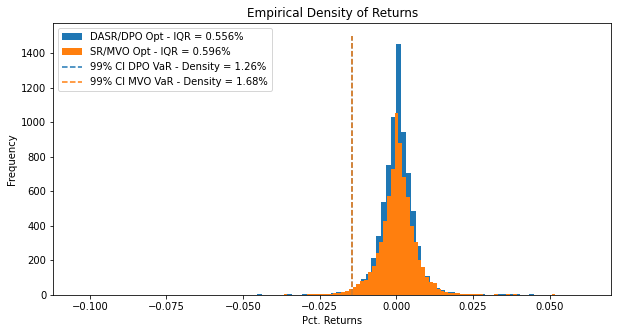

In [10]:
plt.figure(figsize=(10,5))
plt.title('Empirical Density of Returns')


dpo_returns.hist(bins=100, label=f'{dpo_returns.name} - IQR = {np.round(100*(np.percentile(dpo_returns, 75) - np.percentile(dpo_returns, 25)), 3)}%')
mvo_returns.hist(bins=100, label=f'{mvo_returns.name} - IQR = {np.round(100*(np.percentile(mvo_returns, 75) - np.percentile(mvo_returns, 25)), 3)}%')
plt.xlabel("Pct. Returns")
plt.ylabel("Frequency")

dpo_VaR = ra.VaR(dpo_returns, use_laplace=False)[0]
mvo_VaR = ra.VaR(mvo_returns, use_laplace=False)[0]

dpo_VaR_density = np.round(len(dpo_returns.where(dpo_returns<dpo_VaR).dropna()) / len(dpo_returns) * 100, 2)
mvo_VaR_density = np.round(len(mvo_returns.where(mvo_returns<mvo_VaR).dropna()) / len(mvo_returns) * 100, 2)

plt.vlines(dpo_VaR, ymax=1500, ymin=0, label=f'99% CI DPO VaR - Density = {dpo_VaR_density}%', linestyles='--', color='#1f77b4')
plt.vlines(mvo_VaR, ymax=1500, ymin=0, label=f'99% CI MVO VaR - Density = {mvo_VaR_density}%', linestyles='--', color='#ff7f0e')
plt.grid(False)
plt.legend()
plt.show()

Tail-Risk Density

In [138]:
len(dpo_returns.where(dpo_returns<-0.02).dropna()) / len(dpo_returns), len(mvo_returns.where(mvo_returns<-0.02).dropna()) / len(mvo_returns)

(0.004734350341925302, 0.006049447659126775)

Bootstrap Monte Carlo Leptokurtic and Platykurtic Empirical Densities

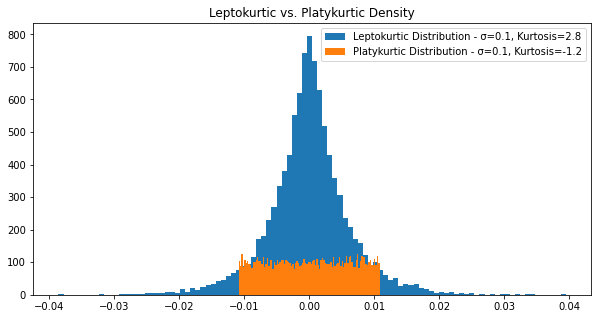

In [623]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example data for a leptokurtic distribution
# Laplace Variance = 2*scale^2 = 2*(.5)^2 = .5
# lepto_data = np.random.laplace(loc=.1, scale=.5, size=(10000, 252*20))
lepto_data = np.random.laplace(loc=0, scale=.5, size=10000)
lepto_data = pt.scale_vol(lepto_data)

# Generate example data for a platykurtic distribution
# platy_data = np.random.uniform(-1.12, 1.32, size=(10000, 252*20))
platy_data = np.random.uniform(-1.22, 1.22, size=10000)
platy_data = pt.scale_vol(platy_data)

# Create a figure with two subplots
plt.figure(figsize=(10,5))

# Plot the histogram of the leptokurtic distribution
plt.hist(lepto_data, bins=100, label=f'Leptokurtic Distribution - σ=0.1, Kurtosis={np.round(stats.kurtosis(lepto_data, fisher=True),1)}')

# Plot the histogram of the platykurtic distribution
plt.hist(platy_data, bins=100, label=f'Platykurtic Distribution - σ=0.1, Kurtosis={np.round(stats.kurtosis(platy_data, fisher=True),1)}')

# Show the plot
plt.legend()
plt.title('Leptokurtic vs. Platykurtic Density')
plt.show()


Simulate High vs. Low Kurtotic Time Series

- Shows that kurtosis is not necessarily bad and may indicate more utility to a trader

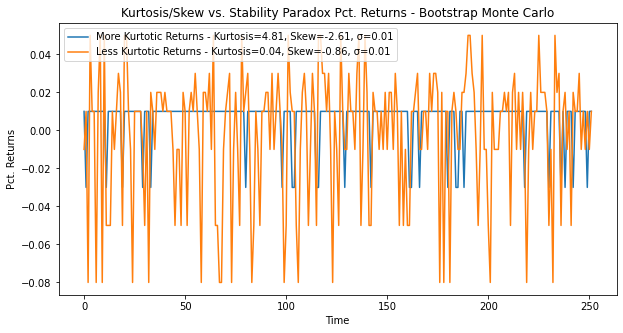

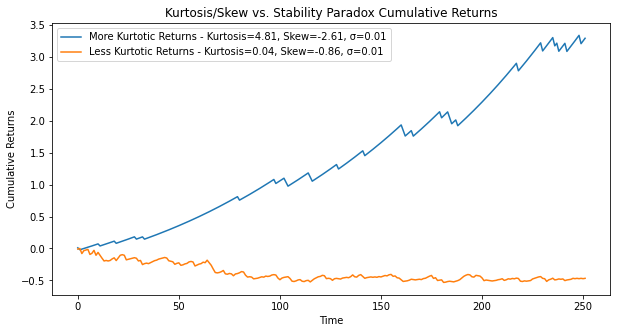

In [12]:
import scipy.stats as stats

sim_dpo = np.array([.01,.01,.01,.01,.01,.01,.01,.01,.01,-.03])
sim_mvo = np.array([.02, -.01, .01, -.05, -.08, .02, .03, .05, -.01, .01])

sim_dpo = np.random.choice(sim_dpo, size=252, replace=True)
sim_mvo = np.random.choice(sim_mvo, size=252, replace=True)

plt.figure(figsize=(10,5))
plt.plot(sim_dpo, label=f'More Kurtotic Returns - Kurtosis={np.round(stats.kurtosis(sim_dpo),2)}, Skew={np.round(stats.skew(sim_dpo),2)}, σ={sim_dpo.std().round(2)}')
plt.plot(sim_mvo, label=f'Less Kurtotic Returns - Kurtosis={np.round(stats.kurtosis(sim_mvo),2)}, Skew={np.round(stats.skew(sim_mvo),2)}, σ={sim_dpo.std().round(2)}')
plt.title('Kurtosis/Skew vs. Stability Paradox Pct. Returns - Bootstrap Monte Carlo')
plt.xlabel("Time")
plt.ylabel("Pct. Returns")
plt.legend(loc='upper left')

plt.figure(figsize=(10,5))
plt.plot(pt.cumulative_returns(sim_dpo), label=f'More Kurtotic Returns - Kurtosis={np.round(stats.kurtosis(sim_dpo),2)}, Skew={np.round(stats.skew(sim_dpo),2)}, σ={sim_dpo.std().round(2)}')
plt.plot(pt.cumulative_returns(sim_mvo), label=f'Less Kurtotic Returns - Kurtosis={np.round(stats.kurtosis(sim_mvo),2)}, Skew={np.round(stats.skew(sim_mvo),2)}, σ={sim_dpo.std().round(2)}')
plt.title('Kurtosis/Skew vs. Stability Paradox Cumulative Returns')
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend(loc='upper left')

Plot optimal weights for DPO & MVO

In [404]:
# dpo_vol_scalar = .1/(np.std((close_asset_returns*dasr_w).sum(1))*252**.5)
# vol_scaled_dpo_weights = dasr_w*dpo_vol_scalar


# plt.figure(figsize=(15, 7))
# plt.bar(vol_scaled_dpo_weights.index, vol_scaled_dpo_weights)
# plt.title(f'DPO Optimal Weights - Portfolio Leverage = {vol_scaled_dpo_weights.sum().round(2)}')
# plt.show()


# mvo_vol_scalar = .1/(np.std((close_asset_returns*mvo_w).sum(1))*252**.5)
# vol_scaled_mvo_weights = mvo_vol_scalar*mvo_w
# plt.figure(figsize=(15, 7))
# plt.bar(vol_scaled_mvo_weights.index, vol_scaled_mvo_weights)
# plt.title(f'MVO Optimal Weights - Portfolio Leverage = {vol_scaled_mvo_weights.sum().round(2)}')
# plt.show()

Get rolling performance metrics

In [402]:
# Get rolling month's SR
rolling_dpo_sr = pt.sharpe_ratio(dpo_returns.rolling(20))
rolling_mvo_sr = pt.sharpe_ratio(mvo_returns.rolling(20))

# Get rolling month's CAGR -- have to do it this weird way because of the underlying functions' inability to handle rolling values
rolling_dpo_cagr = {}
rolling_mvo_cagr = {}
for i, date in enumerate(dpo_returns.iloc[20:].index):
    # SPY
    tmp_dpo_returns = dpo_returns.iloc[20+i-20:20+i-1]
    rolling_dpo_cagr[date] = pt.cagr(tmp_dpo_returns)
    # TAMID
    tmp_mvo_returns = mvo_returns.iloc[20+i-20:20+i-1]
    rolling_mvo_cagr[date] = pt.cagr(tmp_mvo_returns)

rolling_dpo_cagr = pd.Series(rolling_dpo_cagr)
rolling_mvo_cagr = pd.Series(rolling_mvo_cagr)


import backtest_tools.risk_analysis as ra
# Get rolling month's Max DD
rolling_dpo_max_dd = {}
rolling_mvo_max_dd = {}

for i, date in enumerate(dpo_returns.iloc[20:].index):

    # SPY
    tmp_dpo_returns = dpo_returns.iloc[20+i-20:20+i-1]
    try:
        rolling_dpo_max_dd[date] = ra.get_max_n_drawdowns(tmp_dpo_returns, N=1, plot=False).iloc[0]
    except:
        rolling_dpo_max_dd[date] = 0

    # TAMID
    tmp_mvo_returns = mvo_returns.iloc[20+i-20:20+i-1]
    try:
        rolling_mvo_max_dd[date] = ra.get_max_n_drawdowns(tmp_mvo_returns, N=1, plot=False).iloc[0]
    except:
        rolling_mvo_max_dd[date] = 0

rolling_dpo_max_dd = pd.Series(rolling_dpo_max_dd)
rolling_mvo_max_dd = pd.Series(rolling_mvo_max_dd)

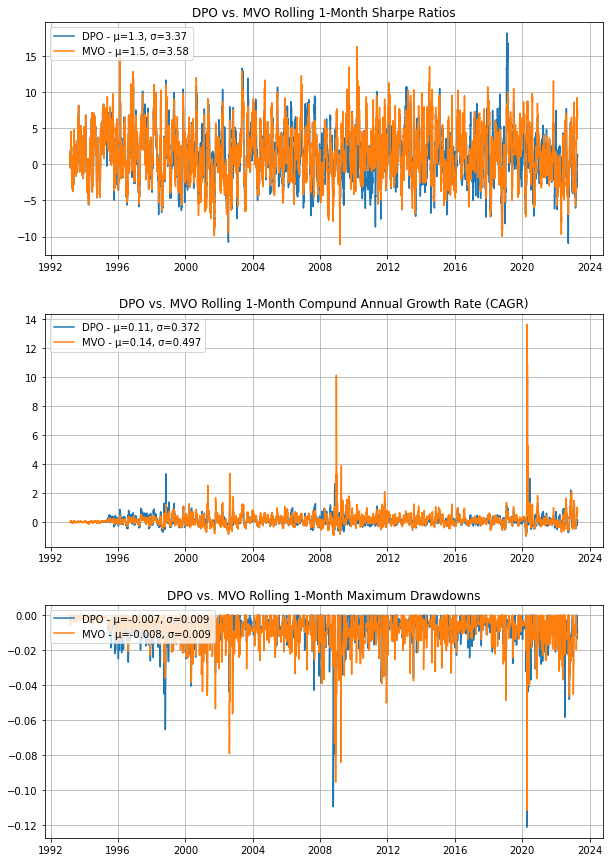

In [407]:
# Create a figure and subplots
import matplotlib as mpl
# mpl.rcParams['font.family'] = 'Courier New'

# Increase the space between subplots


tamid_color = '#41B7EA'

fig, ax = plt.subplots(3,1, figsize=(10, 15))
fig.subplots_adjust(hspace=.25)

# ------------------------------------------ Plot Rolling 1-Month Sharpe Ratios ------------------------------------------ 
# Add gridlines
ax[0].grid()
# Set the 1st subplot's title
ax[0].set_title("DPO vs. MVO Rolling 1-Month Sharpe Ratios")
# Plot each series individually
ax[0].plot(rolling_dpo_sr, label=f'DPO - μ={rolling_dpo_sr.mean().round(1)}, σ={rolling_dpo_sr.std().round(2)}')
ax[0].plot(rolling_mvo_sr, label=f'MVO - μ={rolling_mvo_sr.mean().round(1)}, σ={rolling_mvo_sr.std().round(2)}')
ax[0].legend(loc='upper left')

# ------------------------------------------ Plot Rolling 1-Month Sharpe Ratios ------------------------------------------ 
# Add gridlines
ax[1].grid()
# Set the 1st subplot's title
ax[1].set_title("DPO vs. MVO Rolling 1-Month Compund Annual Growth Rate (CAGR)")
# Plot each series individually
ax[1].plot(rolling_dpo_cagr, label=f'DPO - μ={rolling_dpo_cagr.mean().round(2)}, σ={rolling_dpo_cagr.std().round(3)}')
ax[1].plot(rolling_mvo_cagr, label=f'MVO - μ={rolling_mvo_cagr.mean().round(2)}, σ={rolling_mvo_cagr.std().round(3)}')
# ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax[1].legend(loc='upper left')

# ------------------------------------------ Plot Rolling 1-Month Max Drawdowns ------------------------------------------ 
# Add gridlines
ax[2].grid()
# Set the 1st subplot's title
ax[2].set_title("DPO vs. MVO Rolling 1-Month Maximum Drawdowns")
# Plot each series individually
ax[2].plot(rolling_dpo_max_dd, label=f'DPO - μ={rolling_dpo_max_dd.mean().round(3)}, σ={rolling_dpo_max_dd.std().round(3)}')
ax[2].plot(rolling_mvo_max_dd, label=f'MVO - μ={rolling_mvo_max_dd.mean().round(3)}, σ={rolling_mvo_max_dd.std().round(3)}')
# ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax[2].legend(loc='upper left')

# DPO vs. MVO Performance on Equity Risk Factors/Premia

- Market (Market Risk Premia)
- SMB (Small Minus Big)
- HML (High Minus Low)
- BAB (Betting Against Beta)
- UMD (Up Minus Down)


In [14]:
factor_returns = pd.read_excel(r'C:\Users\marcu\Documents\Quant\Programming\Data\Global Factor Returns - AQR Library.xlsx').set_index('Date')
factor_returns.index = pd.DatetimeIndex(factor_returns.index)

for factor_name, ret in factor_returns.items():
    factor_returns[factor_name] = pt.scale_vol(ret)

factor_returns = factor_returns.loc['2010':].drop(columns='MKT')

<AxesSubplot:title={'center':'Global Equity Factor Cumulative Returns - 10% Vol Scaled'}, xlabel='Time', ylabel='Cumulative Returns'>

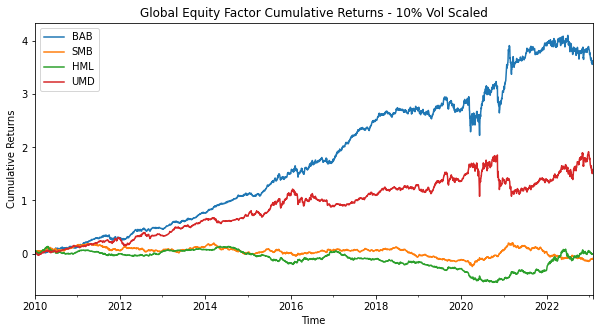

In [15]:
pt.cumulative_returns(factor_returns).plot(figsize=(10, 5), title='Global Equity Factor Cumulative Returns - 10% Vol Scaled', xlabel = "Time", ylabel ="Cumulative Returns")

In [30]:
# Apply DASR Optimization
dasr_w = max_dasr_optimization(returns=factor_returns, constrained=False)
# Apply Mean-Variance Optimization
mvo_w = pt.mvo(hist_returns=factor_returns, expected_returns=factor_returns.mean(), vol_target=None, max_position_weight=3, constrained=False, verbose=False)

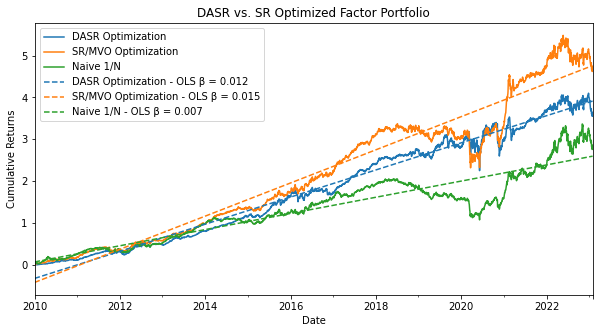

In [31]:
n = len(factor_returns.columns)

# Get portfolio returns
dpo_returns = pt.scale_vol((factor_returns*dasr_w).sum(1))
dpo_returns.name = 'DASR Optimization'
mvo_returns = pt.scale_vol((factor_returns*mvo_w).sum(1))
mvo_returns.name = 'SR/MVO Optimization'
naive_portfolio = pt.scale_vol((factor_returns/n).sum(1))
naive_portfolio.name = 'Naive 1/N'

cumulative_returns = pd.concat([pt.cumulative_returns(dpo_returns), pt.cumulative_returns(mvo_returns), pt.cumulative_returns(naive_portfolio)], axis=1)
cumulative_returns.plot(title='DASR vs. SR Optimized Factor Portfolio', figsize=(10, 5), xlabel='Time', ylabel='Cumulative Returns')

color = {'DASR Optimization':'#1f77b4', 'SR/MVO Optimization':'#ff7f0e', 'Naive 1/N':'#2ca02c'}

# Plot OLS of Cumulative Returns
ols = LinearRegression()

for i, cum_rets in cumulative_returns.items():

    ols.fit(X=np.arange(0,len(cum_rets)).reshape(-1,1), y=cum_rets)
    y_pred = ols.predict(X=np.arange(0,len(cum_rets)).reshape(-1,1))
    y_pred = pd.Series(y_pred, index=cum_rets.index).plot(label=f'{cum_rets.name} - OLS β = {np.round(ols.coef_[0]*10,3)}', linestyle='--', color=color[i])


plt.legend()

In [21]:
def drift_adjusted_sharpe_ratio(returns: pd.Series):
    """ Computes Drift Adjusted Sharpe Ratio by leveraging Min-Max Normalization and OLS Linear Regression. 
        This generates a more robust measure of risk-adjusted returns that account for potentially overfit 
        strategies. The core idea is that large jumps/residuals (positvie or negative) from E[r] are significantly penalized.
        Thus, the DASR rewards consistent returns (closer to best fit line), and penalizes returns series 
        that are largely influenced by large outlier events (i.e., large positive jumps that almost never happen). 
        Although this is a robust measure to capture the statistical signficance of returns, it may not be 
        suitable for highly convex strategies that rely on large positive jumps to enhance 
        their CAGR. 

    Args:
        returns (pd.Series): time series of daily returns.

    Returns:
        float: Drift Adjusted Sharpe Ratio.
    """

    # Get cumulative returns
    returns = returns.dropna()
    cum_rets = pt.cumulative_returns(returns)
    
    # Apply min-max normalization to cumulative returns to ensure all returns are between 0-1
    cum_rets = (cum_rets - cum_rets.min()) / (cum_rets.max() - cum_rets.min())
        
    # Get numerical values of time as exog variable
    date_index = np.arange(cum_rets.index.size)
    exog = sm.add_constant(date_index)  

    # Build model
    model = sm.OLS(cum_rets, exog)
    regression = model.fit()

    # Get regression params
    alpha = regression.params[0]
    beta = regression.params[1]

    # Compute best fit line and format
    reg_pred = date_index * beta + alpha
    reg_pred = pd.Series(reg_pred, index=returns.index, name='Predicted Returns')

    # Build Regression DataFrame
    regression_df = pd.concat([cum_rets, reg_pred], axis=1)

    # Get squared residuls and normalized squared residuals
    regression_df['Squared Error'] = np.square(regression_df.iloc[:,0] - regression_df.iloc[:,1])   
    # regression_df['Cubed Error'] = (regression_df.iloc[:,0] - regression_df.iloc[:,1])**3

    # Get Mean of Squared Residuals
    standardized_mse = np.sum(regression_df['Squared Error']) / np.sqrt(len(returns))
    # mce = regression_df['Cubed Error'].mean()
    
    # Get Drift Adjusted Sharpe Ratio
    drift_adjusted_sharpe_ratio = (beta / standardized_mse) * 252

    return drift_adjusted_sharpe_ratio

In [629]:
# DPO + MVO Portfolio Performance
performance_summary = pd.concat([pt.performance_summary(dpo_returns), pt.performance_summary(mvo_returns)], axis=1)
performance_summary.columns = ['DPO', 'MVO']
performance_summary.index.name = 'Performance Summary'

# Get R^2
dpo_cum_rets = pt.cumulative_returns(dpo_returns)
mvo_cum_rets = pt.cumulative_returns(mvo_returns)

performance_summary.loc['R^2'] = pd.Series({'DPO': LinearRegression().fit(X=np.arange(0,len(dpo_cum_rets)).reshape(-1,1), y=dpo_cum_rets).score(X=np.arange(0,len(dpo_cum_rets)).reshape(-1,1), y=dpo_cum_rets),
                                            'MVO' : LinearRegression().fit(X=np.arange(0,len(mvo_cum_rets)).reshape(-1,1), y=mvo_cum_rets).score(X=np.arange(0,len(mvo_cum_rets)).reshape(-1,1), y=mvo_cum_rets)})

performance_summary

,DPO,MVO
Performance Summary,,
Sharpe Ratio,1.177000,1.338000
Drift Adjusted Sharpe Ratio,56.973000,17.495000
CAGR,0.119000,0.137000
Vol,0.100000,0.100000
Sortino Ratio,1.340000,1.680000
Martin (Ulcer) Ratio,3.523000,3.103000
Omega Ratio,1.105000,1.129000
RR Ratio,1.265000,1.277000
Win Rate,0.565000,0.555000


In [408]:
# Get rolling month's SR
rolling_dpo_sr = pt.sharpe_ratio(dpo_returns.rolling(20))
rolling_mvo_sr = pt.sharpe_ratio(mvo_returns.rolling(20))

# Get rolling month's CAGR -- have to do it this weird way because of the underlying functions' inability to handle rolling values
rolling_dpo_cagr = {}
rolling_mvo_cagr = {}
for i, date in enumerate(dpo_returns.iloc[20:].index):
    # SPY
    tmp_dpo_returns = dpo_returns.iloc[20+i-20:20+i-1]
    rolling_dpo_cagr[date] = pt.cagr(tmp_dpo_returns)
    # TAMID
    tmp_mvo_returns = mvo_returns.iloc[20+i-20:20+i-1]
    rolling_mvo_cagr[date] = pt.cagr(tmp_mvo_returns)

rolling_dpo_cagr = pd.Series(rolling_dpo_cagr)
rolling_mvo_cagr = pd.Series(rolling_mvo_cagr)


import backtest_tools.risk_analysis as ra
# Get rolling month's Max DD
rolling_dpo_max_dd = {}
rolling_mvo_max_dd = {}

for i, date in enumerate(dpo_returns.iloc[20:].index):

    # SPY
    tmp_dpo_returns = dpo_returns.iloc[20+i-20:20+i-1]
    try:
        rolling_dpo_max_dd[date] = ra.get_max_n_drawdowns(tmp_dpo_returns, N=1, plot=False).iloc[0]
    except:
        rolling_dpo_max_dd[date] = 0

    # TAMID
    tmp_mvo_returns = mvo_returns.iloc[20+i-20:20+i-1]
    try:
        rolling_mvo_max_dd[date] = ra.get_max_n_drawdowns(tmp_mvo_returns, N=1, plot=False).iloc[0]
    except:
        rolling_mvo_max_dd[date] = 0

rolling_dpo_max_dd = pd.Series(rolling_dpo_max_dd)
rolling_mvo_max_dd = pd.Series(rolling_mvo_max_dd)

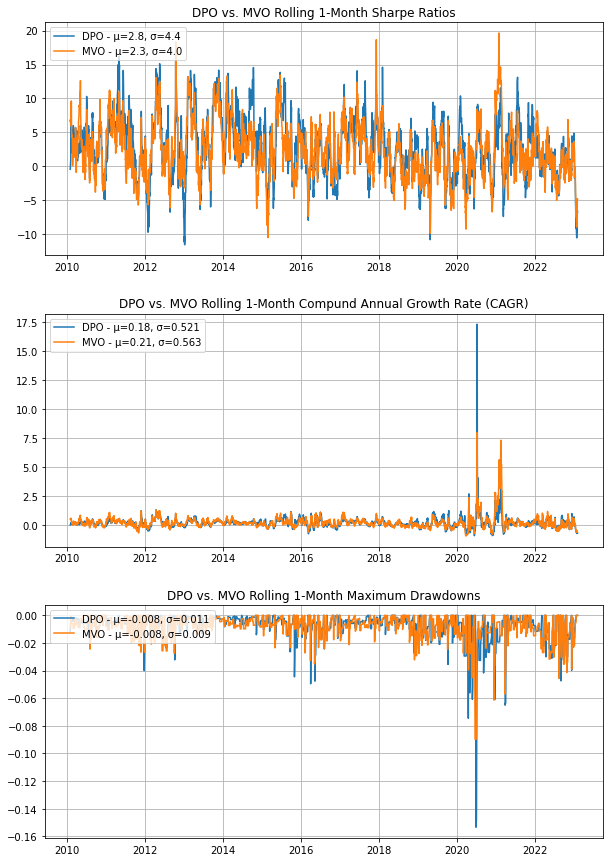

In [409]:
# Create a figure and subplots
import matplotlib as mpl
# mpl.rcParams['font.family'] = 'Courier New'

# Increase the space between subplots


tamid_color = '#41B7EA'

fig, ax = plt.subplots(3,1, figsize=(10, 15))
fig.subplots_adjust(hspace=.25)

# ------------------------------------------ Plot Rolling 1-Month Sharpe Ratios ------------------------------------------ 
# Add gridlines
ax[0].grid()
# Set the 1st subplot's title
ax[0].set_title("DPO vs. MVO Rolling 1-Month Sharpe Ratios")
# Plot each series individually
ax[0].plot(rolling_dpo_sr, label=f'DPO - μ={rolling_dpo_sr.mean().round(1)}, σ={rolling_dpo_sr.std().round(2)}')
ax[0].plot(rolling_mvo_sr, label=f'MVO - μ={rolling_mvo_sr.mean().round(1)}, σ={rolling_mvo_sr.std().round(2)}')
ax[0].legend(loc='upper left')

# ------------------------------------------ Plot Rolling 1-Month Sharpe Ratios ------------------------------------------ 
# Add gridlines
ax[1].grid()
# Set the 1st subplot's title
ax[1].set_title("DPO vs. MVO Rolling 1-Month Compund Annual Growth Rate (CAGR)")
# Plot each series individually
ax[1].plot(rolling_dpo_cagr, label=f'DPO - μ={rolling_dpo_cagr.mean().round(2)}, σ={rolling_dpo_cagr.std().round(3)}')
ax[1].plot(rolling_mvo_cagr, label=f'MVO - μ={rolling_mvo_cagr.mean().round(2)}, σ={rolling_mvo_cagr.std().round(3)}')
# ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax[1].legend(loc='upper left')

# ------------------------------------------ Plot Rolling 1-Month Max Drawdowns ------------------------------------------ 
# Add gridlines
ax[2].grid()
# Set the 1st subplot's title
ax[2].set_title("DPO vs. MVO Rolling 1-Month Maximum Drawdowns")
# Plot each series individually
ax[2].plot(rolling_dpo_max_dd, label=f'DPO - μ={rolling_dpo_max_dd.mean().round(3)}, σ={rolling_dpo_max_dd.std().round(3)}')
ax[2].plot(rolling_mvo_max_dd, label=f'MVO - μ={rolling_mvo_max_dd.mean().round(3)}, σ={rolling_mvo_max_dd.std().round(3)}')
# ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax[2].legend(loc='upper left')

Conduct Hypothesis Testing

In [338]:
from scipy.stats import ttest_ind_from_stats

def two_sample_t_test(mu_1, s_1, n_1, mu_2, s_2, n_2):

    # Calculate the test statistic and p-value
    t, p = ttest_ind_from_stats(mean1=mu_1, std1=s_1, nobs1=n_1, mean2=mu_2, std2=s_2, nobs2=n_2)

    # Print the results
    print("Test statistic:", t)
    print("p-value:", p)

    # Compare p-value with significance level (e.g., 0.05)
    if p < 0.05:
        print("Reject null hypothesis: There is a statistically significant difference in SR between the two strategies.")
    else:
        print("Fail to reject null hypothesis: There is no statistically significant difference in SR between the two strategies.")


# SR of strategy 1
SR1 = pt.sharpe_ratio(dpo_returns)
s1 = dpo_returns.std()*252**.5
n1 = len(dpo_returns.dropna())

# SR of strategy 2
SR2 = pt.sharpe_ratio(mvo_returns)
s2 = mvo_returns.std()*252**.5
n2 = len(mvo_returns.dropna())


two_sample_t_test(SR1, s1, n1, SR2, s2, n2)

Test statistic: -80.17798516968239
p-value: 0.0
Reject null hypothesis: There is a statistically significant difference in SR between the two strategies.


Test the OOS predictive capabilities of DASR vs. SR

In [20]:
import statsmodels.api as sm


def dasr_train_test_split(returns: pd.Series):

    # Eliminate NaN dates for given time series
    returns = returns.dropna()

    # Get train/test split date
    split_index = int(len(returns)/2)

    X_train = returns.dropna().iloc[:split_index]
    X_test = returns.dropna().iloc[split_index:]

    dasr_train = pt.drift_adjusted_sharpe_ratio(X_train)
    dasr_test = pt.drift_adjusted_sharpe_ratio(X_test)
    
    return dasr_train, dasr_test


def dasr_train_sr_test_split(returns: pd.Series):

    # Eliminate NaN dates for given time series
    returns = returns.dropna()

    # Get train/test split date
    split_index = int(len(returns)/2)

    X_train = returns.dropna().iloc[:split_index]
    X_test = returns.dropna().iloc[split_index:]

    dasr_train = pt.drift_adjusted_sharpe_ratio(X_train)
    sr_test = pt.sharpe_ratio(X_test)
    
    return dasr_train, sr_test

def sharpe_ratio_train_test_split(returns: pd.Series):

    # Eliminate NaN dates for given time series
    returns = returns.dropna()

    # Get train/test split date
    split_index = int(len(returns)/2)

    X_train = returns.dropna().iloc[:split_index]
    X_test = returns.dropna().iloc[split_index:]

    sr_train = pt.sharpe_ratio(X_train)
    sr_test = pt.sharpe_ratio(X_test)

    return sr_train, sr_test

def sr_train_dasr_test_split(returns: pd.Series):

    # Eliminate NaN dates for given time series
    returns = returns.dropna()

    # Get train/test split date
    split_index = int(len(returns)/2)

    X_train = returns.dropna().iloc[:split_index]
    X_test = returns.dropna().iloc[split_index:]

    sr_train = pt.sharpe_ratio(X_train)
    dasr_test = pt.drift_adjusted_sharpe_ratio(X_test)

    return sr_train, dasr_test

    
def train_test_ols_regression(returns: pd.DataFrame, metric_function):

    train_test_split = returns.apply(lambda x: metric_function(x)).T.dropna()
    train_test_split.columns = ['X', 'y']

    train_test_split['X'] = ((train_test_split - train_test_split.min()) / (train_test_split.max() - train_test_split.min()))['X']

    # ols = LinearRegression()
    ols = sm.OLS(endog=train_test_split['y'], exog=train_test_split['X']).fit()

    print(ols.summary())

    return ols

def regression_summary(model):
    summary = {}

    summary['Beta'] = model.params[0]
    summary['T-Stat'] = model.tvalues[0]
    summary['R^2'] = model.rsquared
    summary['SE'] = model.bse[0]
    summary['2.5% CI Beta'] = model.conf_int()[0][0]
    summary['97.5% CI Beta'] = model.conf_int()[1][0]
    summary['NOBS'] = model.nobs
    summary['DF'] = model.df_model

    summary = pd.Series(summary)

    return summary

from scipy.stats import t

def regression_beta_one_tailed_ttest(beta_1, se_1, nobs_1, beta_2, se_2):
    """ Conduct one-tailed t-test on two linear regression models to determine if beta_1 > beta_2 
        at a statistically significant level.

    Args:
        beta_1 (_type_): _description_
        se_1 (_type_): _description_
        beta_2 (_type_): _description_
        se_2 (_type_): _description_
        min_nobs (_type_): _description_
    """

    alpha = 0.01

    # Calculate the t-statistic and p-value
    se_diff = np.sqrt(se_1**2 + se_2**2)
    t_stat = (beta_1 - beta_2) / se_diff
    df = nobs_1 - 1
    p_value = 1 - stats.t.cdf(t_stat, df=df)

    # calculate the required t-statistic for a one-tailed t-test with 99% confidence level and 2256 degrees of freedom
    t_crit = t.ppf(1 - alpha, df)

    # Print the results
    print(f"t-stat: {t_stat:.2f}")
    print("Required t-statistic:", t_crit)
    print(f"p-value: {p_value:.4f}")

    # Compare p-value with significance level (e.g., 0.01)
    if p_value < alpha:
        print("Reject null hypothesis: beta_1 > beta_2 at a statistically significant level.")
    else:
        print("Fail to reject null hypothesis: There is no statistically significant inequality.")

In [382]:
# OOS DASR ~ IS DASR
dasr_dasr_ols = train_test_ols_regression(r_2000_returns, dasr_train_test_split)
# OOS SR ~ IS DASR
sr_dasr_ols = train_test_ols_regression(r_2000_returns, dasr_train_sr_test_split)
# OOS SR ~ IS SR
sr_sr_ols = train_test_ols_regression(r_2000_returns, sharpe_ratio_train_test_split)
# OOS DASR ~ IS SR
dasr_sr_ols = train_test_ols_regression(r_2000_returns, sr_train_dasr_test_split)

c:\Users\marcu\Documents\Quant\Programming\backtest_tools\portfolio_tools.py:490: RuntimeWarning: invalid value encountered in double_scalars
  cum_rets = (cum_rets - cum_rets.min()) / (cum_rets.max() - cum_rets.min())


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.053
Model:                            OLS   Adj. R-squared (uncentered):              0.053
Method:                 Least Squares   F-statistic:                              127.0
Date:                Tue, 18 Apr 2023   Prob (F-statistic):                    1.09e-28
Time:                        23:41:47   Log-Likelihood:                         -8415.8
No. Observations:                2256   AIC:                                  1.683e+04
Df Residuals:                    2255   BIC:                                  1.684e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

c:\Users\marcu\Documents\Quant\Programming\backtest_tools\portfolio_tools.py:490: RuntimeWarning: invalid value encountered in double_scalars
  cum_rets = (cum_rets - cum_rets.min()) / (cum_rets.max() - cum_rets.min())


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.569
Model:                            OLS   Adj. R-squared (uncentered):              0.569
Method:                 Least Squares   F-statistic:                              2975.
Date:                Tue, 18 Apr 2023   Prob (F-statistic):                        0.00
Time:                        23:41:55   Log-Likelihood:                         -792.14
No. Observations:                2256   AIC:                                      1586.
Df Residuals:                    2255   BIC:                                      1592.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [391]:
dasr_dasr_ols_summary = regression_summary(dasr_dasr_ols)
dasr_dasr_ols_summary

Beta                6.567376
T-Stat             11.267293
R^2                 0.053297
SE                  0.582871
2.5% CI Beta        5.424356
97.5% CI Beta       7.710395
NOBS             2256.000000
DF                  1.000000
dtype: float64

In [392]:
sr_dasr_ols_summary = regression_summary(sr_dasr_ols)
sr_dasr_ols_summary

Beta                1.083194
T-Stat             54.541963
R^2                 0.568819
SE                  0.019860
2.5% CI Beta        1.044249
97.5% CI Beta       1.122139
NOBS             2256.000000
DF                  1.000000
dtype: float64

In [397]:
sr_sr_ols_summary = regression_summary(sr_sr_ols)
sr_sr_ols_summary

Beta                0.741023
T-Stat             55.762278
R^2                 0.579639
SE                  0.013289
2.5% CI Beta        0.714963
97.5% CI Beta       0.767083
NOBS             2256.000000
DF                  1.000000
dtype: float64

In [394]:
dasr_sr_ols_summary = regression_summary(dasr_sr_ols)
dasr_sr_ols_summary

Beta                3.890619
T-Stat              9.784721
R^2                 0.040728
SE                  0.397622
2.5% CI Beta        3.110876
97.5% CI Beta       4.670362
NOBS             2256.000000
DF                  1.000000
dtype: float64

Conduct one-tailed t-test to determine the statistical significance of DASR's superiority

In [399]:
# OOS DASR ~ IS DASR vs. OOS SR ~ IS SR
regression_beta_one_tailed_ttest(beta_1=dasr_dasr_ols_summary.loc['Beta'], se_1=dasr_dasr_ols_summary.loc['SE'], nobs_1=sr_sr_ols_summary.loc['NOBS'],
                                 beta_2=sr_sr_ols_summary.loc['Beta'], se_2=sr_sr_ols_summary.loc['SE'])
regression_beta_one_tailed_ttest(beta_1=sr_sr_ols_summary.loc['Beta'], se_1=sr_sr_ols_summary.loc['SE'], nobs_1=sr_sr_ols_summary.loc['NOBS'],
                                 beta_2=dasr_dasr_ols_summary.loc['Beta'], se_2=dasr_dasr_ols_summary.loc['SE'])

# OOS DASR ~ IS DASR vs. OOS SR ~ IS DASR
regression_beta_one_tailed_ttest(beta_1=dasr_dasr_ols_summary.loc['Beta'], se_1=dasr_dasr_ols_summary.loc['SE'], nobs_1=dasr_dasr_ols_summary.loc['NOBS'],
                                 beta_2=sr_dasr_ols_summary.loc['Beta'], se_2=sr_dasr_ols_summary.loc['SE'])
regression_beta_one_tailed_ttest(beta_1=sr_dasr_ols_summary.loc['Beta'], se_1=sr_dasr_ols_summary.loc['SE'], nobs_1=sr_dasr_ols_summary.loc['NOBS'],
                                 beta_2=dasr_dasr_ols_summary.loc['Beta'], se_2=dasr_dasr_ols_summary.loc['SE'])

regression_beta_one_tailed_ttest(beta_1=sr_dasr_ols_summary.loc['Beta'], se_1=sr_dasr_ols_summary.loc['SE'], nobs_1=sr_sr_ols_summary.loc['NOBS'],
                                 beta_2=sr_sr_ols_summary.loc['Beta'], se_2=sr_sr_ols_summary.loc['SE'])

regression_beta_one_tailed_ttest(beta_1=sr_dasr_ols_summary.loc['Beta'], se_1=sr_dasr_ols_summary.loc['SE'], nobs_1=sr_sr_ols_summary.loc['NOBS'],
                                 beta_2=sr_sr_ols_summary.loc['Beta'], se_2=sr_sr_ols_summary.loc['SE'])

regression_beta_one_tailed_ttest(beta_1=dasr_dasr_ols_summary.loc['Beta'], se_1=dasr_dasr_ols_summary.loc['SE'], nobs_1=dasr_dasr_ols_summary.loc['NOBS'],
                                 beta_2=dasr_sr_ols_summary.loc['Beta'], se_2=dasr_sr_ols_summary.loc['SE'])

t-stat: 3.79
Required t-statistic: 2.328002690909571
p-value: 0.0001
Reject null hypothesis: beta_1 > beta_2 at a statistically significant level.


# DASR Optimization Strategy Class

In [4]:
from scipy.optimize import minimize
from scipy.optimize import Bounds


class dasr_optimized_portfolio():

    def __init__(self, tickers: list, lookback_window: int, rebal_freq: int):

        self.tickers = tickers
        self.lookback_window = lookback_window
        self.rebal_freq = rebal_freq
    
        # Get investment unverse's daily returns
        self.close_returns, self.open_returns = self.get_returns(tickers)

        # Backtest Strategy
        self.strategy_returns, self.portfolio_weights = self.run(self.close_returns, self.open_returns, self.lookback_window, self.rebal_freq)

    def get_returns(self, tickers: list):
        
        # Returns of opening prices
        open_asset_returns = pd.DataFrame()
        
        # Returns of close prices
        close_asset_returns = pd.DataFrame()

        for ticker in tickers:

            prices = yf.download(ticker, start='1970-01-01', end=dt.date.today())
            
            # Get i'th asset's returns
            close_rets = prices['Adj Close'].pct_change().dropna()
            close_rets = close_rets.rename(ticker)
            open_rets = prices['Open'].pct_change().dropna()
            open_rets = open_rets.rename(ticker)

            close_asset_returns = pd.concat([close_asset_returns, close_rets], axis=1)
            open_asset_returns = pd.concat([open_asset_returns, open_rets], axis=1)

        return(close_asset_returns, open_asset_returns)

    
    def portfolio_dasr(self, w: pd.Series, returns: pd.DataFrame) ->  float:
        """ Computes DASR of weighted portfolio.

        Args:
            betas (pd.Series): daily expected returns from normalized linear regression.
            squared_residuals (pd.DataFrame): squared error from OLS regression.
            w (pd.Series): portfolio weights.

        Returns:
            float: _description_
        """

        # Get weighted returns
        returns = (returns * w).sum(1)
        
        # Get weighted portfolio DASR
        portfolio_dasr = pt.drift_adjusted_sharpe_ratio(returns.dropna())
        
        # Return negative DASR for portfolio optimization
        return (-portfolio_dasr)

    def max_dasr_optimization(self, returns: pd.DataFrame) -> pd.Series:
        """ Executes constrained convex portfolio optimization to generate optimal
            DASR asset weights.

        Args:
            returns (pd.DataFrame): Asset returns.

        Returns:
            pd.Series: Optimal DASR portfolio weights.
        """

        n = len(returns.columns)

        # Initial guess is naive 1/n portfolio
        w = np.array([1 / n] * n)

        # Max position size L/S
        bounds = Bounds(-.5, .5)

        constraints =  [# Weights Constraint
                        {"type": "eq", "fun": lambda w: np.sum(np.abs(w)) - 1},
                        # {"type": "eq", "fun": lambda w: np.sum(w) - 0},
                        ]

        # Get optimized weights
        w = pd.Series(minimize(self.portfolio_dasr, 
                                w,
                                args=(returns), 
                                method='SLSQP',
                                bounds = bounds,
                                constraints=constraints)['x'],
                    index=returns.columns
                    )
        
        return w
    
    def run(self, close_returns: pd.DataFrame, open_returns: pd.DataFrame, lookback_window: int, rebal_freq: int):
        
        # Declare weights hash table
        w = {}

        # Get optimized weights at rebal_freq intervals
        for date in close_returns.index[::rebal_freq]:
            w[date] = self.max_dasr_optimization(returns=close_returns.loc[:date].tail(lookback_window))

        # Convert Hash Table to DataFrame
        indices_df = pd.DataFrame(index=close_returns.index)
        w = pd.concat([indices_df, pd.DataFrame(w).T], axis=1).ffill().dropna()

        # Get strategy returns
        strategy_returns = (open_returns*w.shift(2)).sum(1).dropna()

        return (strategy_returns, w)

    def performance_analysis(self, start_date = dt.date(2004, 1, 1)):

        # Print Investment Universe
        print(self.tickers)
        
        # Plot Unscaled Strategy Returns
        pt.cumulative_returns(self.strategy_returns.loc[start_date:]).plot(label='Strategy Returns', legend=True)

        # Plot Vol Scaled Strategy Returns
        scaled_strategy_returns = pt.scale_vol(self.strategy_returns.loc[start_date:])
        pt.cumulative_returns(scaled_strategy_returns).plot(label='Strategy Returns - 10% Vol Scaled', legend=True)

        # Plot 1/N Naive Portfolio as Benchmark Returns
        n = len(self.tickers)
        naive_portfolio = pt.scale_vol((self.open_returns.loc[start_date:]/n).sum(1))
        pt.cumulative_returns(naive_portfolio).plot(label='Naive 1/N Returns - 10% Vol Scaled', legend=True)

        # Plot 50/50 Portfolio of Returns
        combined_portfolio = (.5 * scaled_strategy_returns + .5 * naive_portfolio)
        pt.cumulative_returns(combined_portfolio).plot(label='Combined Opt + Naive Portfolio - 10% Vol Scaled', legend=True)

        # Optimized DASR Portfolio Performance
        strategy_performance_summary = pt.performance_summary(scaled_strategy_returns)
        strategy_performance_summary.index.name = 'Strategy Returns'

        # Naive Portfolio Performance
        naive_performance_summary = pt.performance_summary(naive_portfolio)
        naive_performance_summary.index.name = 'Naive 1/N Returns'

        # 50/50 Combined Portfolio Performance
        combined_portfolio_performance_summary = pt.performance_summary(combined_portfolio)
        combined_portfolio_performance_summary.index.name = 'Combined Portfolio'

        # Update attribute values 
        self.strategy_performance_summary = strategy_performance_summary
        self.naive_performance_summary = naive_performance_summary
        self.combined_strategy_performance_summary = combined_portfolio_performance_summary   
        

Utility Functions

In [5]:
# -------------------------------------- Function to Compute DASR-Related Data --------------------------------------
def get_drift_adjusted_sharpe_ratio_data(returns: pd.Series):
    """ Computes Drift Adjusted Sharpe Ratio by leveraging Min-Max Normalization and OLS Linear Regression. 
        This generates a more robust measure of risk-adjusted returns that account for potentially overfit 
        strategies. The core idea is that large jumps/residuals (positvie or negative) from E[r] are significantly penalized.
        Thus, the DASR rewards consistent returns (closer to best fit line), and penalizes returns series 
        that are largely influenced by large outlier events (i.e., large positive jumps that almost never happen). 
        Although this is a robust measure to capture the statistical signficance of returns, it may not be 
        suitable for highly convex strategies that rely on large positive jumps to enhance 
        their CAGR. 

    Args:
        returns (pd.Series): time series of daily returns.

    Returns:
        tuple: Drift Adjusted Sharpe Ratio, Beta, Squared Residuals.
    """

    # Get cumulative returns
    returns = returns.dropna()
    cum_rets = (1 + returns).cumprod() - 1
    
    # Apply min-max normalization to cumulative returns to ensure all returns are between 0-1
    cum_rets = (cum_rets - cum_rets.min()) / (cum_rets.max() - cum_rets.min())
        
    # Get numerical values of time as exog variable
    date_index = np.arange(cum_rets.index.size)
    exog = sm.add_constant(date_index)  

    # Build model
    model = sm.OLS(cum_rets, exog)
    regression = model.fit()

    # Get regression params
    alpha = regression.params[0]
    beta = regression.params[1]

    # Compute best fit line and format
    reg_pred = date_index * beta + alpha
    reg_pred = pd.Series(reg_pred, index=returns.index, name='Predicted Returns')

    # Build Regression DataFrame
    regression_df = pd.concat([cum_rets, reg_pred], axis=1)

    # Get squared residuls and normalized squared residuals
    regression_df['Squared Error'] = np.square(regression_df.iloc[:,0] - regression_df.iloc[:,1])   
    # regression_df['Cubed Error'] = (regression_df.iloc[:,0] - regression_df.iloc[:,1])**3

    # Get Mean of Squared Residuals
    mse = regression_df['Squared Error'].mean()
    # mce = regression_df['Cubed Error'].mean()
    
    # Get Drift Adjusted Sharpe Ratio
    drift_adjusted_sharpe_ratio = (beta / mse) * 252

    return drift_adjusted_sharpe_ratio, beta, regression_df['Squared Error']

In [6]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
# -------------------------------------- Portfolio Optimization Functions --------------------------------------
def portfolio_dasr(w: pd.Series, returns: pd.DataFrame, neg = True) ->  float:
    """ Computes DASR of weighted portfolio.

    Args:
        betas (pd.Series): daily expected returns from normalized linear regression.
        squared_residuals (pd.DataFrame): squared error from OLS regression.
        w (pd.Series): portfolio weights.

    Returns:
        float: _description_
    """

    # Get weighted returns
    returns = (returns * w).sum(1)
    # Get weighted portfolio DASR
    portfolio_dasr = pt.drift_adjusted_sharpe_ratio(returns.dropna())

    if neg:
        # Return negative DASR for portfolio optimization
        return (-portfolio_dasr)
    
    # Return real DASR for performance analysis purposes
    return portfolio_dasr

def max_dasr_optimization(returns: pd.DataFrame, long_only=False, constrained=True) -> pd.Series:
    """ Executes constrained convex portfolio optimization to generate optimal
        DASR asset weights.

    Args:
        returns (pd.DataFrame): Asset returns.

    Returns:
        pd.Series: Optimal DASR portfolio weights.
    """

    n = len(returns.columns)

    # Initial guess is naive 1/n portfolio
    w = np.array([1 / n] * n)

    if constrained:

        # Max position size L/S
        if long_only:
            bounds = Bounds(0, 1)
        else:
            bounds = Bounds(-.5, .5)

        constraints =  [# Weights Constraint
                {"type": "eq", "fun": lambda w: np.sum(np.abs(w)) - 1},
                # {"type": "eq", "fun": lambda w: np.sum(w) - 0},

                ]
    else:
        constraints = []
        bounds = Bounds(-50, 50)

    # Get optimized weights
    w = pd.Series(minimize(portfolio_dasr, 
                            w,
                            args=(returns), 
                            method='SLSQP',
                            bounds = bounds,
                            constraints=constraints)['x'],
                index=returns.columns
                )
    
    return w

# Abandoned Idea:

Potential Portfolio DASR = Portfolio Beta (Expected Return) / Portfolio Variance of Squared Residuals

- This metric was an attempt to mirror the methodology of MVO where a portfolio variance and expected return are computed based on portfolio weights.
- This metric, although initially intuitive, generates mispecified portfolios since DASR does not use variance of squared error as its denomintator, but rather MSE.
- This metric also generates too lowly volatile portfolios that cannot generate return unless highly levered.

    weighted_beta = np.dot(betas, w)
    squared_residuals_variance = w.T.dot(squared_residuals.T.dot(squared_residuals)/(len(squared_residuals) - 1)).dot(w)
    defunct_portfolio_dasr = weighted_beta / squared_residuals_variance

In [36]:
# # Generate random portfolio weights vector
# w = np.random.rand(close_asset_returns.shape[1])
# w = w / w.sum()

# # Compute portfolio DASR - do not use - is not technically DASR
# defunct_portfolio_dasr = w.T.dot(betas) / w.T.dot(squared_residuals.T.dot(squared_residuals)/(len(squared_residuals) - 1)).dot(w)